In [1]:
import warnings
import tensorflow as tf
tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, Activation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from math import ceil

2024-06-05 15:59:34.599178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 15:59:34.599274: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 15:59:34.729470: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
img_path = "/kaggle/input/fercomplilation/"
data = pd.read_csv(img_path + 'fer2013.csv')
labels = pd.read_csv(img_path+ 'fer2013new.csv')
FERnew_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt','unknown','NF']
FER_classes = ['neutral', 'happiness', 'surprise', 'sadness', 'anger', 'disgust', 'fear', 'contempt']

samples = len(data)
width = 48
height = 48

# Initialize x and y values
y = np.array(labels[FERnew_classes])
x = np.zeros((samples, width, height, 1))

for i in range(samples):
    x[i] = np.fromstring(data['pixels'][i], dtype=int, sep=' ').reshape((width, height, 1))

print(len(x))
print(len(y))

35887
35887


In [3]:
# Remove unknown and Not a Face (NF) images from both data(x) and labels(y)
indices_to_remove = []
for i in range(0,len(y)):
    max_label = np.argmax(y[i],axis = 0)
    if(max_label == 9 or max_label == 8):
        indices_to_remove.append(i)
x = np.delete(x,indices_to_remove,axis = 0)
y = np.delete(y,indices_to_remove,axis = 0)
y = y[:, :-2]
print(len(indices_to_remove))
print(len(x))
print(len(y))

399
35488
35488


In [4]:
# Label all images to particular emotions based on votes in fer2013new.csv 
label = []
for i in range(0,len(y)):
    max_label_index = np.argmax(y[i]) 
    label.append(max_label_index)
y = np.array(label)

# Conversion to binary class matrix
y = to_categorical(y)

# Normalize images
x = x / 255.0

In [5]:
# Get split size
test_size = ceil(len(x) * 0.1)
print(len(x))
print(test_size)
# 3549

# Split Data
x_train, x_test, y_train, y_test =train_test_split(x, y, test_size=test_size, random_state=42)
x_train, x_val, y_train, y_val =train_test_split(x_train, y_train, test_size=test_size,random_state=42)

35488
3549


In [6]:
# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    height_shift_range=0.1,
    width_shift_range=0.1
)
datagen.fit(x_train)

In [7]:
img_shape = (48,48,1)
classes= len(FER_classes)

model = Sequential()

# Block 1
model.add(Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=img_shape))
model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 2
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 3
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 4
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Block 5
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(512, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

# Classification block
model.add(Flatten())
model.add(Dense(4096, activation='relu'))
model.add(Dense(4096, activation='relu'))
model.add(Dense(classes, activation='softmax'))

model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     2,101,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │        32,77

 Total params: 38,938,568 (148.54 MB)

 Trainable params: 38,938,568 (148.54 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
batch_size = 64

history = model.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                    epochs=100,
                    steps_per_epoch=len(x_train) // batch_size,
                    validation_data=(x_val, y_val),
                    verbose=2)

Epoch 1/100


I0000 00:00:1717603219.827113      86 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1717603219.850091      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1717603255.860655      87 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


443/443 - 73s - 165ms/step - accuracy: 0.3589 - loss: 1.6285 - val_accuracy: 0.3677 - val_loss: 1.5852
Epoch 2/100
443/443 - 2s - 4ms/step - accuracy: 0.4844 - loss: 1.3855 - val_accuracy: 0.3677 - val_loss: 1.5871
Epoch 3/100
443/443 - 35s - 79ms/step - accuracy: 0.3627 - loss: 1.6033 - val_accuracy: 0.3677 - val_loss: 1.5730
Epoch 4/100
443/443 - 2s - 4ms/step - accuracy: 0.3438 - loss: 1.4971 - val_accuracy: 0.3677 - val_loss: 1.5735
Epoch 5/100
443/443 - 35s - 79ms/step - accuracy: 0.3760 - loss: 1.5706 - val_accuracy: 0.4491 - val_loss: 1.4708
Epoch 6/100
443/443 - 2s - 4ms/step - accuracy: 0.5312 - loss: 1.4903 - val_accuracy: 0.4483 - val_loss: 1.4847
Epoch 7/100
443/443 - 35s - 79ms/step - accuracy: 0.4617 - loss: 1.4693 - val_accuracy: 0.5523 - val_loss: 1.3234
Epoch 8/100
443/443 - 2s - 4ms/step - accuracy: 0.6094 - loss: 1.2430 - val_accuracy: 0.5548 - val_loss: 1.3195
Epoch 9/100
443/443 - 35s - 79ms/step - accuracy: 0.5522 - loss: 1.3151 - val_accuracy: 0.6052 - val_loss: 

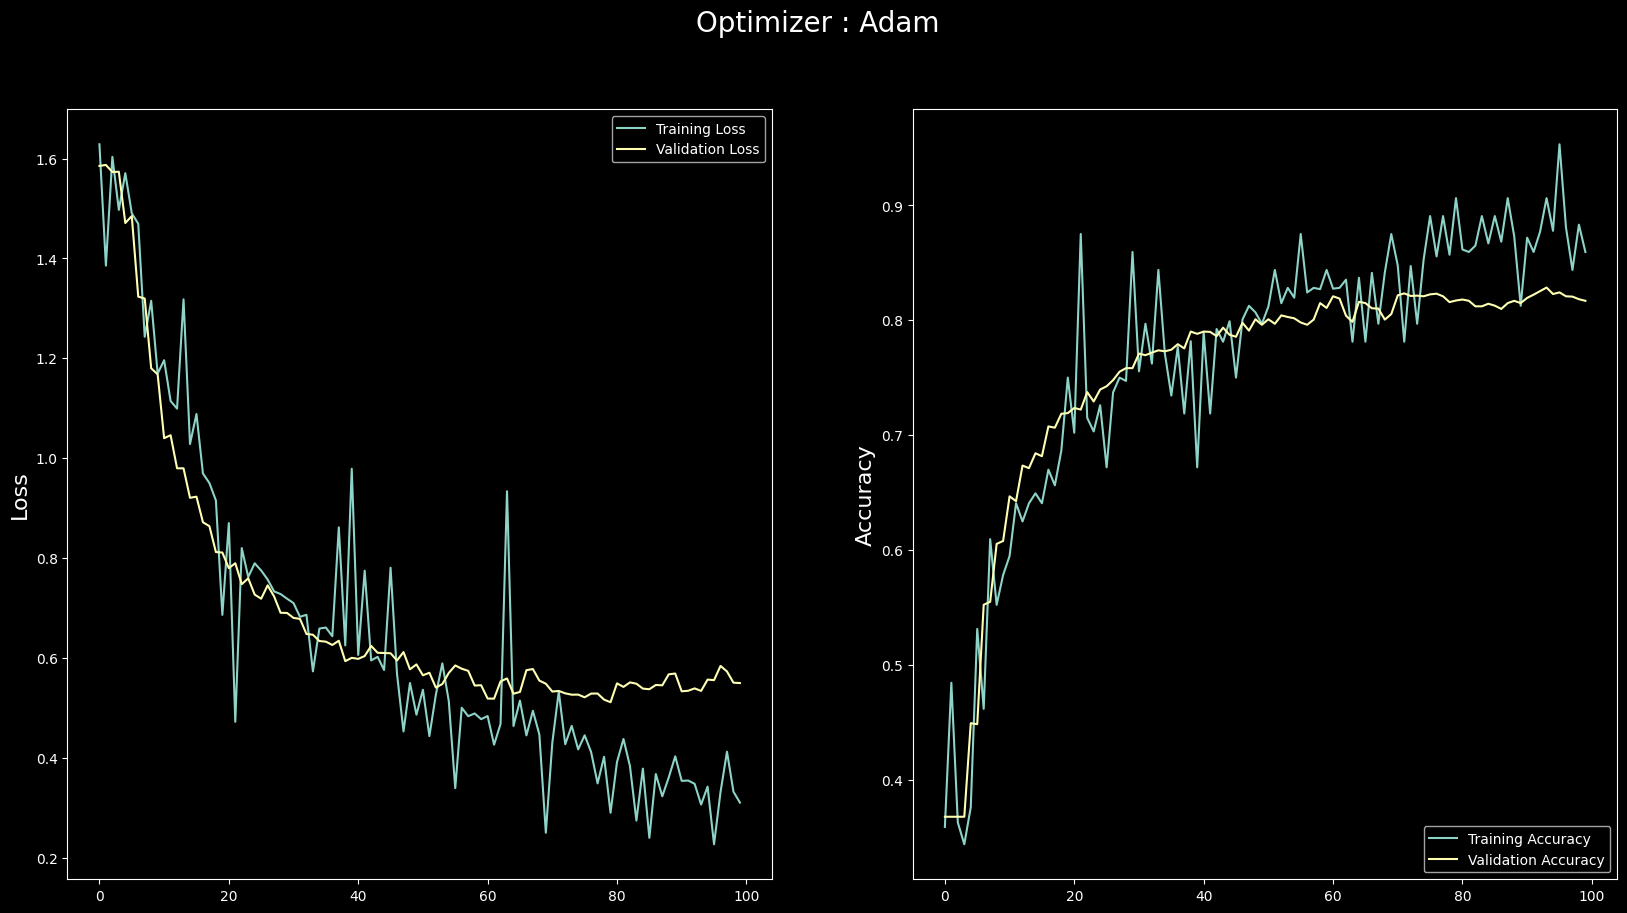

In [9]:
# Plot training & validation accuracy and loss VS epochs 
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=20)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [10]:
model.evaluate(x_test, y_test, batch_size=batch_size)

 7/56 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.8388 - loss: 0.5729 

W0000 00:00:1717605097.839537      86 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - accuracy: 0.8282 - loss: 0.5774


[0.5833752751350403, 0.8219216465950012]

In [11]:
model.save("emosense_model.h5")